SPARQL Transformer evaluation
=========================

This notebook contains some quantitative measures for the evaluation of SPARQL Transformer.

In [1]:
import json
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import FloatProgress
from IPython.display import display

from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLTransformer import sparqlTransformer

In [2]:
input_folder = './sparql'
ENDPOINT = 'http://dbpedia.org/sparql'

In [3]:
json_queries_files = list(filter(lambda x: x.endswith('.json'), os.listdir(input_folder)))
json_queries_files.sort()
rq_queries_files = [f.replace('.json', '.rq') for f in json_queries_files]

json_queries = [json.load(open('%s/%s' % (input_folder, f), 'r')) for f in json_queries_files]
rq_queries = [open('%s/%s' % (input_folder, f), 'r').read() for f in rq_queries_files]

json_queries_files

['1.Born_in_Berlin.json',
 '2.German_musicians.json',
 '3.Musicians_born_in_Berlin.json',
 '4.Soccer_players.json',
 '5.Games.json']

The test queries have been taken from the __[DBpedia wiki](https://wiki.dbpedia.org/OnlineAccess)__.

Those SELECT queries have been manually converted in json query, making sure that the transformed query was equal to the original one (variable names apart).

The following table shows, for each query:
- `n vars`, how many variable are selected
- `levels`, how many levels are present in the json prototype, considered that `1` refers to a flat object (all properties attached to the root) and `2` at one level of nested object
- `features` included in the query
        
| name                     | n vars | levels | features             |
|--------------------------|--------|--------|----------------------|
|1.Born_in_Berlin          |   4    |   1    | filter, orderby      |
|2.German_musicians        |   4    |   1    | lang filter, optional|
|3.Musicians_born_in_Berlin|   4    |   1    | lang filter          |
|4.Soccer_players          |   5    |   2    | filter, orderby      |
|5.Games                   |   2    |   1    | orderby              |

Functions for executing the query and returning the bindings.

- For JSON queries, we use **SPARQLTransformer**.
- For SPARQL queries, we use **SPARQLWrapper** (which is also internally used by SPARQLTransformer).

In [4]:
def sparql_exec(query):
    sparql = SPARQLWrapper(ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query().convert()
    return result["results"]["bindings"]

def json_exec(query, debug=False):
    return sparqlTransformer(query, {'endpoint': ENDPOINT, 'debug': debug})

Functions for running the test for a particular query (sparql or json).

The test measure the **execution time** of the query (including any parsing task) and the **number of results**.

In [5]:
def test_atom(query, typ='sparql'):
    start = time.time()
    if typ == 'sparql':
        r = sparql_exec(query)
    else:
        r = json_exec(query)
    
    end = time.time()
    timing = end - start
    
    return len(r), timing

We will execute the test multiple times for each query, to obtain an average result as much as possible not correlated to the network/server workload.

In particular, each test would be executed `num_iteration` times. Each couple of consecutive iteration will be separated by `sleep_time` seconds.

In [6]:
num_iteration = 100
sleep_time = 3

In [7]:
test_results = []
all_timings = []

for i, json_query in enumerate(json_queries):
    # queries
    json_query = json_queries[i]
    rq_query = rq_queries[i]
    title = rq_queries_files[i].replace('.rq', '')
    print(title)
    
    # progress bars
    fs = FloatProgress(min=0, max=num_iteration, description='SPARQL test:')
    display(fs)
    fj = FloatProgress(min=0, max=num_iteration, description='JSON test:')
    display(fj)

    
    sparql_time = []
    sparql_results = 0
    json_time = []
    json_results = 0
    
    for j in np.arange(num_iteration):
        if (i + j) > 0 :
            time.sleep(sleep_time)
        sparql_results, t = test_atom(rq_query, typ='sparql')
        sparql_time.append(t)
        fs.value += 1

    for j in np.arange(num_iteration):
        time.sleep(sleep_time)
        json_results, t = test_atom(json_query, typ='json')
        json_time.append(t)
        fj.value += 1
    
    
    ts = np.mean(sparql_time) 
    tj = np.mean(json_time)
    time_diff = (tj - ts)
    time_diff_percent = 100 * time_diff / np.mean([ts,tj])
    
    test_results.append({
        'name': title,
        'time_sparql': ts, 
        'result_sparql': sparql_results,
        'time_json': np.mean(json_time) , 
        'result_json': json_results,
        'time_diff': '{0:.2g}'.format(time_diff),
        'time_diff_percent': '{0:.2g}%'.format(time_diff_percent)
    });

    all_timings.append({
        'name': title,
        'json': json_time,
        'sparql': sparql_time
    })

1.Born_in_Berlin


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='JSON test:')

2.German_musicians


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='JSON test:')

3.Musicians_born_in_Berlin


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='JSON test:')

4.Soccer_players


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='JSON test:')

5.Games


FloatProgress(value=0.0, description='SPARQL test:')

FloatProgress(value=0.0, description='JSON test:')

In [8]:
all_timings

[{'json': [0.5688645839691162,
   0.41646790504455566,
   0.4115588665008545,
   0.3931729793548584,
   0.41626501083374023,
   0.4175441265106201,
   0.4374821186065674,
   0.39827919006347656,
   0.4342968463897705,
   0.4021458625793457,
   0.4373190402984619,
   0.3961358070373535,
   0.42986011505126953,
   0.40839290618896484,
   0.4064786434173584,
   0.46083784103393555,
   0.4191291332244873,
   0.41135525703430176,
   0.41289591789245605,
   0.41425013542175293,
   0.4213981628417969,
   0.4259676933288574,
   0.4274318218231201,
   0.4176449775695801,
   0.4066658020019531,
   0.43497300148010254,
   0.39820122718811035,
   0.43195223808288574,
   0.4139561653137207,
   0.4231123924255371,
   0.4232289791107178,
   0.4248981475830078,
   0.42540812492370605,
   0.44663214683532715,
   0.4898219108581543,
   0.4119408130645752,
   0.4221968650817871,
   0.41364216804504395,
   0.4026150703430176,
   0.43102478981018066,
   0.403688907623291,
   0.5212960243225098,
   0.411384

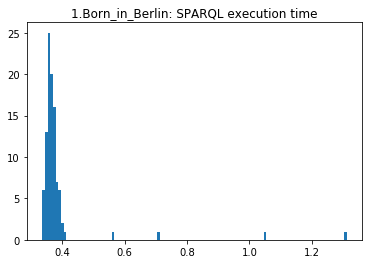

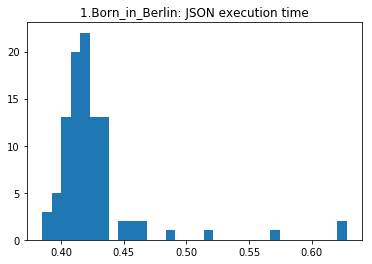

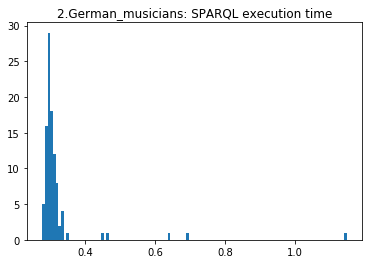

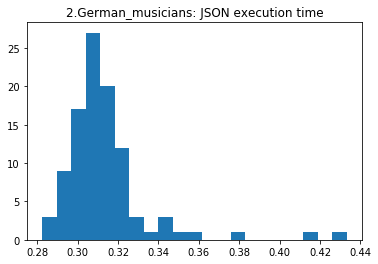

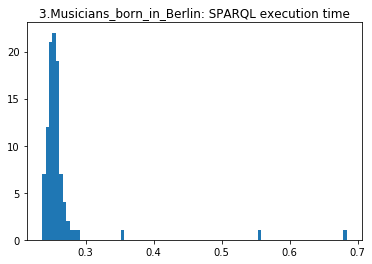

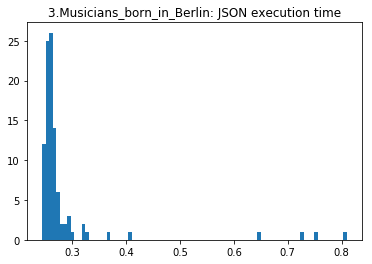

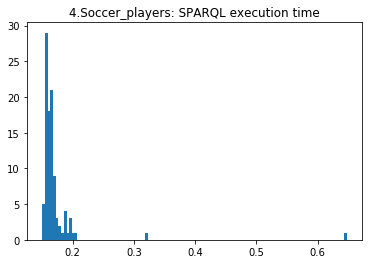

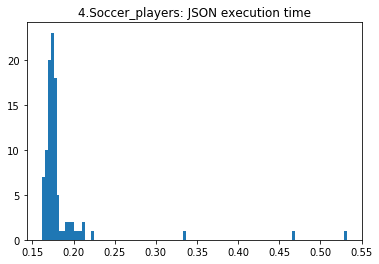

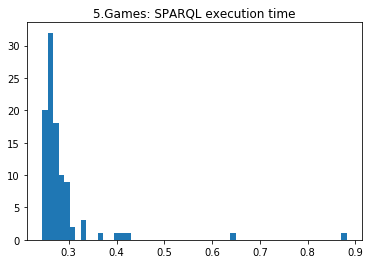

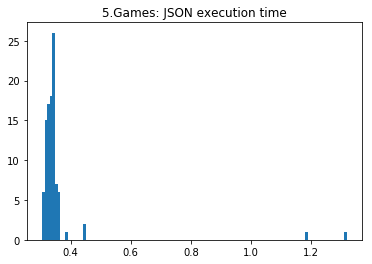

In [9]:
for i, json_query in enumerate(json_queries):
    tim = all_timings[i]
    name = tim['name']
    
    a = np.hstack(tim['sparql'])
    plt.hist(a, bins='auto')  # arguments are passed to np.histogram
    plt.title(name + ': SPARQL execution time')
    plt.show()
    
    a = np.hstack(tim['json'])
    plt.hist(a, bins='auto')  # arguments are passed to np.histogram
    plt.title(name + ': JSON execution time')
    plt.show()

In [10]:
pd.DataFrame.from_dict(test_results)

,name,result_json,result_sparql,time_diff,time_diff_percent,time_json,time_sparql
0,1.Born_in_Berlin,573,1132,0.04,9.9%,0.426117,0.386062
1,2.German_musicians,278,317,-0.0079,-2.5%,0.313542,0.321474
2,3.Musicians_born_in_Berlin,154,227,0.023,8.4%,0.285086,0.262116
3,4.Soccer_players,77,85,0.013,7.1%,0.184664,0.171919
4,5.Games,1043,1084,0.07,22%,0.355559,0.285310


The table give us two different informations.

#### Time difference

The execution time of JSON queries (`time_json`) is quite close to the one of SPARQL ones (`time_sparql`). The difference in percentage (`time_diff`) never overcomes the +10%, which usually corresponds to few hundredths of a second.

> This is not in line with the results (which are weird, I will repeat the test outside EURECOM network).

#### Result difference

The number of results (bindings) returned by SPARQL Transformer (`result_json`) is always lower than the ones returned by the endpoint (`result_json`). This is due to the fact that the latter represents all the combination of values as distinct bindings, while the former aggregates the results with the same id.

### Example of result for `1.Born_in_Berlin`.

An interest case is the 2nd result about [Prince Adalbert of Prussia](http://dbpedia.org/resource/Prince_Adalbert_of_Prussia_(1811–1873)), which has 4 names and 2 differently formatted death date. This is represented with 4 * 2 = 8 bindings, then merged with SPARQL Transformer

In [11]:
# SPARQL query
sparql_exec(rq_queries[0])[1:9]

[{'birth': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
   'type': 'typed-literal',
   'value': '1811-10-29'},
  'death': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
   'type': 'typed-literal',
   'value': '1873-06-06'},
  'name': {'type': 'literal', 'value': '()', 'xml:lang': 'en'},
  'person': {'type': 'uri',
   'value': 'http://dbpedia.org/resource/Prince_Adalbert_of_Prussia_(1811–1873)'}},
 {'birth': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
   'type': 'typed-literal',
   'value': '1811-10-29'},
  'death': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
   'type': 'typed-literal',
   'value': '1873-6-6'},
  'name': {'type': 'literal', 'value': '()', 'xml:lang': 'en'},
  'person': {'type': 'uri',
   'value': 'http://dbpedia.org/resource/Prince_Adalbert_of_Prussia_(1811–1873)'}},
 {'birth': {'datatype': 'http://www.w3.org/2001/XMLSchema#date',
   'type': 'typed-literal',
   'value': '1811-10-29'},
  'death': {'datatype': 'http://www.w3.org/2001/XM

In [12]:
# SPARQL query
json_exec(json_queries[0])[1]

{'birth': '1811-10-29',
 'death': ['1873-06-06', '1873-6-6'],
 'id': 'http://dbpedia.org/resource/Prince_Adalbert_of_Prussia_(1811–1873)',
 'name': [{'language': 'en', 'value': '()'},
  {'language': 'en', 'value': '(Henry William Adalbert)'},
  {'language': 'en', 'value': 'Adalbert of Prussia'},
  {'language': 'en', 'value': 'Prince Adalbert'}]}

In [13]:
test_results

[{'name': '1.Born_in_Berlin',
  'result_json': 573,
  'result_sparql': 1132,
  'time_diff': '0.04',
  'time_diff_percent': '9.9%',
  'time_json': 0.42611743450164796,
  'time_sparql': 0.38606163263320925},
 {'name': '2.German_musicians',
  'result_json': 278,
  'result_sparql': 317,
  'time_diff': '-0.0079',
  'time_diff_percent': '-2.5%',
  'time_json': 0.3135420799255371,
  'time_sparql': 0.3214744210243225},
 {'name': '3.Musicians_born_in_Berlin',
  'result_json': 154,
  'result_sparql': 227,
  'time_diff': '0.023',
  'time_diff_percent': '8.4%',
  'time_json': 0.2850861096382141,
  'time_sparql': 0.26211575746536253},
 {'name': '4.Soccer_players',
  'result_json': 77,
  'result_sparql': 85,
  'time_diff': '0.013',
  'time_diff_percent': '7.1%',
  'time_json': 0.18466359853744507,
  'time_sparql': 0.17191943645477295},
 {'name': '5.Games',
  'result_json': 1043,
  'result_sparql': 1084,
  'time_diff': '0.07',
  'time_diff_percent': '22%',
  'time_json': 0.35555879354476927,
  'time_